In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = (6,6)

from collections import Counter

import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Dense
from keras.applications import ResNet50
# from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

from keras.optimizers import Adam 

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy.misc import imresize
from skimage.io import imread

from sklearn.model_selection import train_test_split

/home/zh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



# 数据预处理部分


In [2]:
ratings = pd.read_excel('SCUT-FBP5500_with_Landmarks/All_Ratings.xlsx')
ratings.head()

,Email,Filename,Rating,original Rating
0,1,ftw1.jpg,3,NaN
1,1,ftw10.jpg,3,NaN
2,1,ftw100.jpg,1,NaN
3,1,ftw101.jpg,2,NaN
4,1,ftw102.jpg,3,NaN


In [3]:
img_width, img_height, channels = 350, 350, 3
sample_dir = 'SCUT-FBP5500_with_Landmarks/Images/'
nb_samples = len(os.listdir(sample_dir))
input_shape = (img_width, img_height, channels)

In [4]:
filenames = ratings.groupby('Filename').size().index.tolist()

labels = []

for filename in filenames:
    df = ratings[ratings['Filename'] == filename]
    count = Counter(df['Rating']).most_common(1)[0][0]
    score = round(df['Rating'].mean(), 2)
    labels.append({'Filename': sample_dir+filename, 'most_common': count, 'score': score})

labels_df = pd.DataFrame(labels)
labels_df.head()

,Filename,most_common,score
0,SCUT-FBP5500_with_Landmarks/Images/ftw1.jpg,4,4.12
1,SCUT-FBP5500_with_Landmarks/Images/ftw10.jpg,3,3.55
2,SCUT-FBP5500_with_Landmarks/Images/ftw100.jpg,2,2.13
3,SCUT-FBP5500_with_Landmarks/Images/ftw101.jpg,3,2.48
4,SCUT-FBP5500_with_Landmarks/Images/ftw102.jpg,3,3.30


In [5]:
seed = 29 
files = [sample_dir+i for i in os.listdir(sample_dir)]
train_files, test_files = train_test_split(files, test_size=0.1, random_state=seed)
train_files[:5]

['SCUT-FBP5500_with_Landmarks/Images/fty1636.jpg',
 'SCUT-FBP5500_with_Landmarks/Images/mty1771.jpg',
 'SCUT-FBP5500_with_Landmarks/Images/mty1997.jpg',
 'SCUT-FBP5500_with_Landmarks/Images/mtw544.jpg',
 'SCUT-FBP5500_with_Landmarks/Images/mtw235.jpg']

In [6]:
def image_generator(files, batch_size):
    while True:
        for i in range(0, len(files)//batch_size):
            x = np.empty(shape=(batch_size, img_width, img_height, channels), dtype=np.float)
            y = np.empty(shape=(batch_size, 1), dtype=np.float)
            for k, j in enumerate(range(i*batch_size, (i+1)*batch_size)):
                x[k] = imread(files[j]) / 255.
                y[k] = labels_df[labels_df.Filename==files[j]].score.values.astype('float')
            yield x, y


# 训练


In [7]:
batch_size = 16

In [8]:
resnet = ResNet50(include_top=False, pooling='avg', input_shape=input_shape)
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
filepath="mse-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=1,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callback_list = [checkpoint, reduce_learning_rate, early_stop]


model.compile(loss='mse', optimizer=Adam(lr=0.0001))

history = model.fit_generator(generator=image_generator(train_files, batch_size),
                              steps_per_epoch=len(train_files)//batch_size,
                              validation_data=image_generator(test_files, batch_size),
                              validation_steps=len(test_files)//batch_size,
                              callbacks=callback_list,
                              epochs=20)

Epoch 1/20
309/309 [==============================] - 151s 488ms/step - loss: 0.3745 - val_loss: 0.2109

Epoch 00001: val_loss improved from inf to 0.21090, saving model to mse-01-0.2109.h5
Epoch 2/20
309/309 [==============================] - 143s 464ms/step - loss: 0.1171 - val_loss: 0.2277

Epoch 00002: val_loss did not improve from 0.21090
Epoch 3/20
309/309 [==============================] - 145s 469ms/step - loss: 0.1243 - val_loss: 0.1488

Epoch 00003: val_loss improved from 0.21090 to 0.14880, saving model to mse-03-0.1488.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 4/20
309/309 [==============================] - 137s 444ms/step - loss: 0.0626 - val_loss: 0.1254

Epoch 00004: val_loss improved from 0.14880 to 0.12542, saving model to mse-04-0.1254.h5
Epoch 5/20
309/309 [==============================] - 138s 446ms/step - loss: 0.0352 - val_loss: 0.1042

Epoch 00005: val_loss improved from 0.12542 to 0.10419, saving model to mse-05-0.1042.h5
Epoch 6

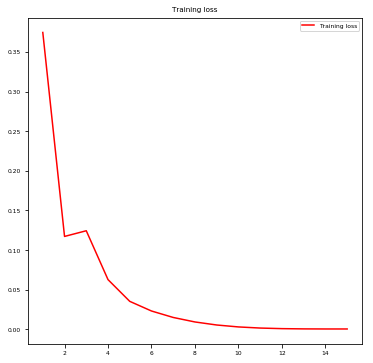

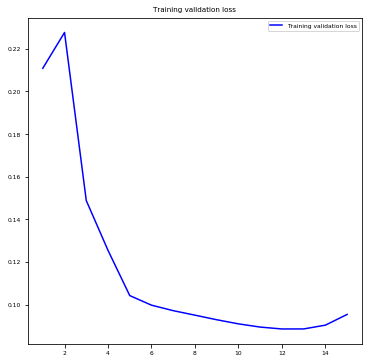

In [10]:
plt.rcParams['figure.figsize'] = (6,6)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.title('Training loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.legend()

plt.figure()
plt.title('Training validation loss')
plt.plot(epochs, val_loss, 'blue', label='Training validation loss')
plt.legend()

plt.show()

In [11]:
from keras.models import load_model

best_model = load_model('mse-12-0.0885.h5')

In [12]:
y_pred = best_model.predict_generator(generator=image_generator(train_files, batch_size), 
                                      steps=len(train_files)//batch_size)

In [13]:
y_train = np.empty(shape=(len(train_files), 1), dtype=np.float)
for i, k in enumerate(train_files):
    y_train[i] = labels_df[labels_df.Filename==k].score.values.astype('float')

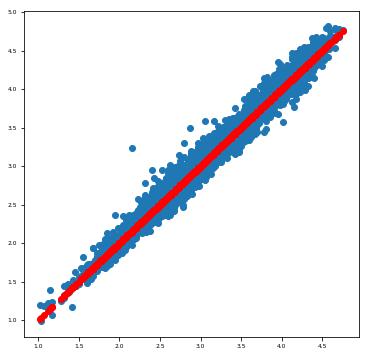

In [14]:
plt.scatter(y_train[:y_pred.shape[0]], y_pred)
plt.plot(y_train, y_train, 'ro')

In [15]:
test_pred = best_model.predict_generator(generator=image_generator(test_files, batch_size),
                                         steps=len(test_files)//batch_size)

In [16]:
y_test = np.empty(shape=(len(test_files), 1), dtype=np.float)
for i, k in enumerate(test_files):
    y_test[i] = labels_df[labels_df.Filename==k].score.values.astype('float')

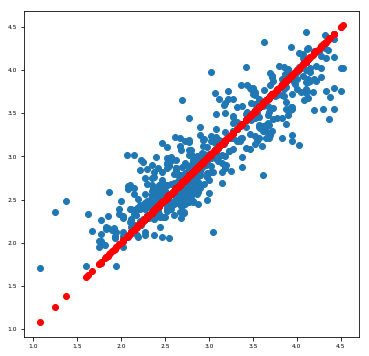

In [17]:
plt.scatter(y_test[:test_pred.shape[0]], test_pred)
plt.plot(y_test, y_test, 'ro')

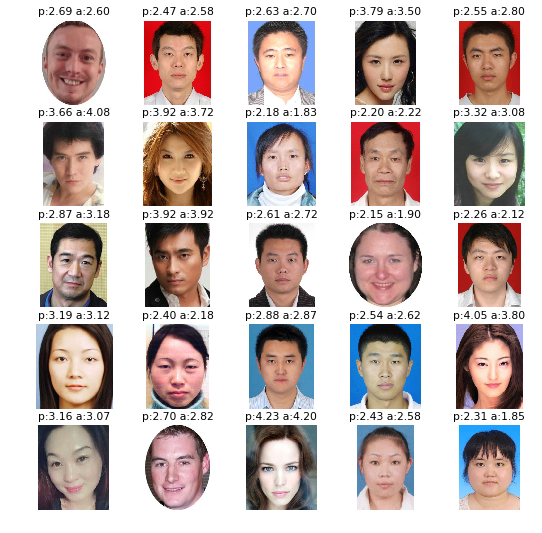

In [18]:
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (9,9)

from random import randint
nb_test_samples = len(test_files)
nb_rows, nb_cols = 5, 5

def check_test_result():
    for k in range(nb_rows * nb_cols):
        i = randint(0, nb_test_samples - 1)
        x = imread(test_files[i]) / 255.
        y = labels_df[labels_df.Filename==test_files[i]].score.values
        predicted = best_model.predict(x.reshape((1,) + x.shape))
        plt.subplot(nb_rows, nb_cols, k+1)
        plt.imshow(x)
        plt.title("p:%.2f a:%.2f" % (predicted[0][0], y))
        plt.axis('off')

check_test_result()

predicted: 3.95


/home/zh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


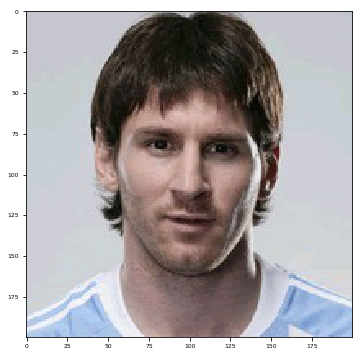

In [19]:
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = (6,6)

img = load_img('messi.jpg')
plt.imshow(img)
img = imresize(img, size=(img_height, img_width))
test_x = img_to_array(img).reshape(img_height, img_width, channels)
test_x = test_x / 255.
test_x = test_x.reshape((1,) + test_x.shape)
predicted = best_model.predict(test_x)
print("predicted: %.2f" % predicted[0][0])